# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Исследование содержит данные супермаркета, включающие фотографии покупателей с указанием их возраста. Основная задача — разработать модель машинного обучения, которая по фотографии будет определять приблизительный возраст человека, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования**:

Построить модель компьютерного зрения для точного определения возраста по фотографии.

Таким образом, исследование пройдёт в **4 этапа**:
1) Обзор данных

2) Исследовательский анализ данных

3) Обучение модели

4) Анализ результатов

 **Условия проекта**:
- Значение метрики MAE на тестовой выборке не больше 8.

## Загрузка и обзор данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию, описательную статистику DataFrame,
    количество пропущенных значений и явных дубликатов.

    '''
    display(df.head())
    df.info()
    display(df.describe().T.round(3))
    print('Количество пропусков:',
          df.isna().sum(), sep='\n', end='\n\n')
    print('Количество дубликатов:', 
          df.duplicated().sum())

In [3]:
# Загрузка датафрейма
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
# Вывод общей информации о датафрейме 'labels'
data_info(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201,17.145,1.0,20.0,29.0,41.0,100.0


Количество пропусков:
file_name    0
real_age     0
dtype: int64

Количество дубликатов: 0


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Размер данных составляет 7591 и включает в себя фотографии людей и указанный для них возраст (от 1 до 100 лет).
- В данных отсутствуют пропущенные значения и дубликаты.

## Исследовательский анализ данных

Проанализируем распределение возраста в представленной выборке:

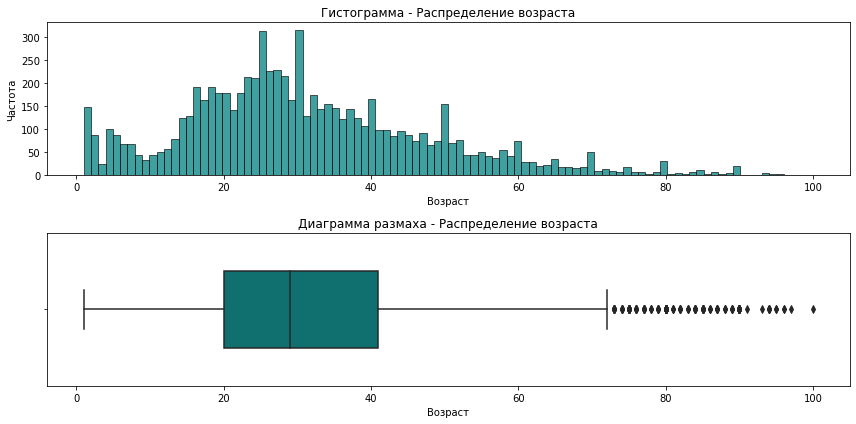

In [5]:
# Графики распределения возраста
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Гистограмма
sns.histplot(data=labels, x='real_age', bins=100, color='teal', ax=ax1)
ax1.set_title('Гистограмма - Распределение возраста')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')

# Диаграмма размаха
sns.boxplot(data=labels, x='real_age', ax=ax2, color='teal', width=.5)
ax2.set_title('Диаграмма размаха - Распределение возраста')
ax2.set_xlabel('Возраст')

plt.tight_layout()
plt.show()

Found 7591 validated image filenames.


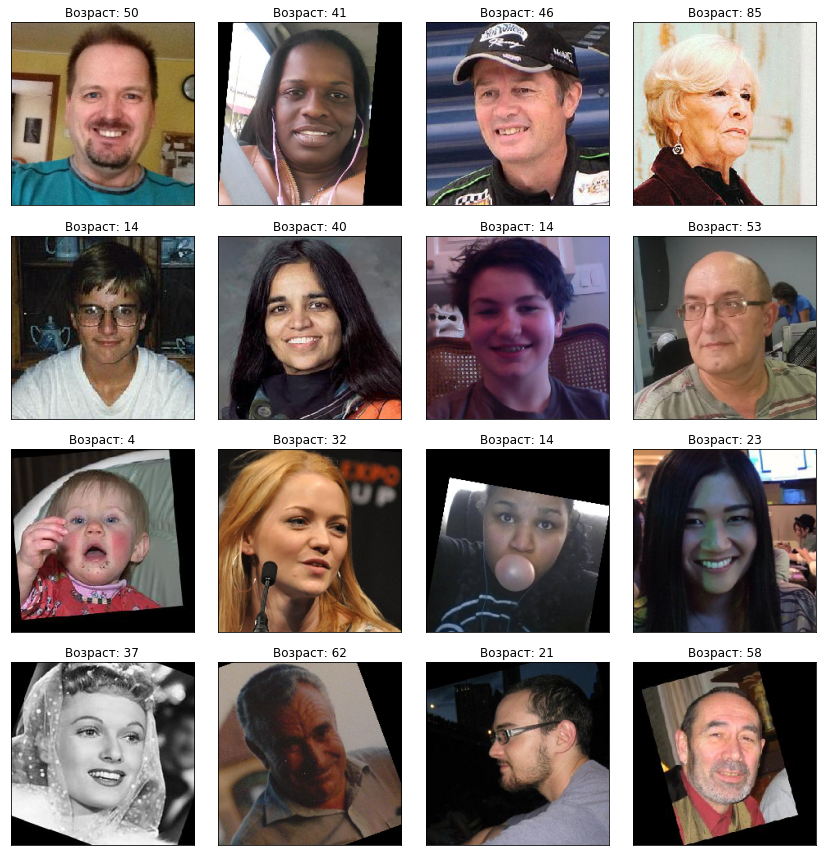

In [6]:
# Загрузка фотографий
datagen = ImageDataGenerator(rescale=1./255)

faces_datagen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=16,
    seed=12345
)

# Извлечение одного батча данных
image, age = next(faces_datagen)

# Вывод 16 фотографий
fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(image[i])
    plt.title(f'Возраст: {age[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**
- Основная масса данных сосредоточена в диапазоне от 15 до 40 лет. Очень мало данных для возрастных групп от 70 лет и старше. Такое неравномерное распределение может существенно повлиять на обучение модели. Большая концентрация данных в одной возрастной группе может привести к смещению модели, что повлияет на точность предсказаний для возрастных групп с недостаточным количеством данных (младше 10 и старше 70 лет).
- Часть фотографий сделано под углом, имеют низкую резкость, присутствует различное освещение и фон. Все эти факторы могут повлиять на точность модели. Для улучшения качества модели применим аугментацию изображений.

## Обучение модели

Создадим функции для подготовки данных и обучения свёрточной нейронной сети.

In [7]:
def load_train(path):
    '''
    Загружает и подготавливает тренировочный набор данных.

    Args:
        path (str): Путь к папке с данными
        
    Returns:
        train_data (DirectoryIterator): Генератор данных для обучения

    ------
    - Выполняется аугментация изображений, включая:
        - Горизонтальное отражение.
        - Повороты в пределах ±20°.
        - Смещения по ширине и высоте до 20%.
        - Изменение яркости в пределах ±20%.
    - Значения пикселей нормализуются в диапазоне [0, 1].
    - Данные разделяются на тренировочную (75%) и валидационную (25%) выборки.
    - Генератор возвращает батчи по 16 изображений.
    '''
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1.0 / 255,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2]
    )

    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=16,
        subset='training', 
        seed=12345
    )
        
    return train_data

In [8]:
def load_test(path):
    '''
    Загружает и подготавливает тестовый набор данных.

    Args:
        path (str): Путь к папке с данными
        
    Returns:
        test_data (DirectoryIterator): Генератор данных для валидации

    ------
    - Генератор выполняет только нормализацию значений пикселей в диапазоне [0, 1].
    - Данные разделяются на тренировочную (75%) и валидационную (25%) выборки.
    - Генератор возвращает данные из валидационной выборки.
    - Батчи содержат по 16 изображений.
    '''
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1.0 / 255
    )

    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=16,
        subset='validation', 
        seed=12345
    )
        
    return test_data

In [9]:
def create_model(input_shape):
    '''
    Создаёт и возвращает модель для предсказания возраста на основе ResNet50.

    Args:
        input_shape(tuple): Размер входных данных.
        
    Returns:
        model (keras.models.Sequential): Модель нейронной сети, готовая для обучения.

    Архитектура модели:
        1. Backbone: ResNet50 с предварительно обученными весами ImageNet, без верхних слоёв.
        2. GlobalAveragePooling2D: Уменьшение размерности выходов ResNet50 для обработки их Dense-слоем.
        3. Dense (выходной слой): Один нейрон с функцией активации ReLU для предсказания возраста.

    Компиляция:
        - Loss: `mean_absolute_error`.
        - Optimizer: Adam с learning_rate=1e-4.
        - Metrics: MAE.
    '''
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [10]:
def train_model(model, train_data, test_data, 
                batch_size=None, epochs=10, 
                steps_per_epoch=None, 
                validation_steps=None):
    '''
    Обучает переданную модель на тренировочных данных и оценивает её на валидационной выборке.

    Args:
       model(keras.Model): Модель, которую нужно обучить.
       train_data (DirectoryIterator): Генератор тренировочных данных, возвращающий батчи изображений и меток.
       test_data (DirectoryIterator): Генератор данных для валидации, возвращающий батчи изображений и меток.
       batch_size (int, optional): Размер батча для обучения. По умолчанию `None`.
       epochs (int, optional): Количество эпох для обучения. По умолчанию 10.
       steps_per_epoch (int, optional): Количество шагов в каждой эпохе. По умолчанию `None`.
       validation_steps (int, optional): Количество шагов для валидации на эпоху. По умолчанию `None`.

    Returns:
        model (keras.Model): Обученная модель.
    '''
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 148s - loss: 10.9797 - mae: 10.9800 - val_loss: 26.2420 - val_mae: 26.2449
Epoch 2/10
356/356 - 144s - loss: 8.2943 - mae: 8.2937 - val_loss: 9.4923 - val_mae: 9.4790
Epoch 3/10
356/356 - 144s - loss: 7.6968 - mae: 7.6970 - val_loss: 7.3825 - val_mae: 7.3770
Epoch 4/10
356/356 - 143s - loss: 7.2017 - mae: 7.2019 - val_loss: 8.2544 - val_mae: 8.2648
Epoch 5/10
356/356 - 143s - loss: 6.8186 - mae: 6.8188 - val_loss: 6.3922 - val_mae: 6.3943
Epoch 6/10
356/356 - 144s - loss: 6.4527 - mae: 6.4530 - val_loss: 6.8106 - val_mae: 6.8146
Epoch 7/10
356/356 - 142s - loss: 6.1800 - mae: 6.1806 - val_loss: 7.7935 - val_mae: 7.8009
Epoch 8/10
356/356 - 143s - loss: 5.9215 - mae: 5.9211 - val_loss: 6.4528 - val_mae: 6.4517
Epoch 9/10
356/356 - 143s - loss: 5.7742 - mae: 5.7743 - val_loss: 7.6605 - val_mae: 7.6642
Epoch 10/10
356/356 - 142s - loss: 5.5506 - mae: 5.5511 - val_loss: 6.5687 - val_mae: 6.5714

119/119 - 14s - loss: 6.5687 - mae: 6.5714

```

## Анализ результатов

1) **Использованная архитектура модели**

Модель основана на архитектуре ResNet50 с предварительно обученными весами на ImageNet. Этот бэкбон был выбран за свою способность извлекать высокоуровневые признаки из изображений. В модели используется:
 - ResNet50 в качестве бэкбона, который исключает верхние слои, чтобы использовать только предобученные веса для извлечения признаков.
 - GlobalAveragePooling2D для уменьшения размерности выходных данных.
 - Dense слой с одним нейроном и активацией ReLU для предсказания возраста.

2) **Параметры обучения**
- Оптимизатор: был использован Adam с коэффициентом обучения 1e-4.
- Размер батча: был установлен размер 16 (для балансировки между скоростью обучения и стабильностью градиентного спуска).
- Количество эпох: модель обучалась на протяжении 10 эпох. В процессе обучения наблюдалось стабильное снижение ошибки на тренировочной выборке, тогда как на валидации улучшения метрик происходили до 5-й эпохи, после чего начались колебания. Финальная ошибка на валидации (MAE: 6.5714) сопоставима с тренировочной, что свидетельствует о минимальном уровне переобучения.
- Заморозка весов бэкбона: не использовалась заморозка весов бэкбона.

3) **Достигнутые метрики**

Модель достигла следующих результатов на валидационной выборке:
- **loss: 6.5687**
- **MAE: 6.5714**. 

Эти метрики говорят о том, что модель в среднем ошибается на 6.5 лет при определении возраста, что удовлетворяет требованиям задачи.

4) **Итоги исследования**

Целью исследования было создание модели для предсказания возраста по фотографии, с целью её использования в рекомендательных системах и для контроля за продажей алкоголя. Для задачи *рекомендательных систем* данная модель с ошибкой около 6 лет вполне подходит, так как позволяет предлагать товары, соответствующие предполагаемой возрастной категории. Однако для *контроля за продажей алкоголя*, где требуется более высокая точность в определении возраста, модель с такой ошибкой может быть недостаточной, так как возможны погрешности, которые приведут к ошибочному отказу в продаже или наоборот — к продаже алкоголя несовершеннолетним.

Для улучшения качества предсказания модели можно использовать следующие методы:
- Увеличение данных для младших и пожилых возрастных групп, что позволит модели лучше понять особенности этих возрастов.
- Обучение отдельных моделей для разных возрастных категорий (например, одна модель для младшего возраста, другая - для старшего).